# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/AE/Sparse_AE/jetnet/'

Mounted at /content/drive


In [2]:
from torch.utils.data import random_split, Dataset, DataLoader
import pandas as pd
import numpy as np
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, mean_absolute_error
import torch.nn.utils.prune as prune
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

# File Viewing

In [ ]:
def print_structure(file_name):
    with h5py.File(file_name, 'r') as f:
        f.visititems(print_item)

def print_item(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(name, obj.shape, obj.dtype)
    elif isinstance(obj, h5py.Group):
        print(name)

file_name = path + 't.hdf5'
print_structure(file_name)

jet_features (177945, 4) float32
particle_features (177945, 30, 4) float32


In [ ]:
with h5py.File(file_name, 'r') as f:
    jet_features_data = f['jet_features'][:]
    particle_features_data = f['particle_features'][:]

In [ ]:
def explore_hdf5(filename):
    with h5py.File(filename, 'r') as file:
        # Explore the file's datasets
        for name, dataset in file.items():
            print(f"Dataset name: {name}")
            print(f"Shape: {dataset.shape}")
            print(f"Datatype: {dataset.dtype}")
            print(f"Content (first 1 elements): {dataset[:2]}")
            print("------")

        # If you specifically want to see the labels (assuming they are in a dataset named 'labels'):
        if 'labels' in file:
            print(f"Labels: {file['labels'][:]}")

explore_hdf5(file_name)

Dataset name: jet_features
Shape: (177945, 4)
Datatype: float32
Content (first 1 elements): [[ 1.00083856e+03 -1.02152944e+00  1.73566376e+02  3.00000000e+01]
 [ 9.81978027e+02 -1.26148816e-02  1.09439171e+02  3.00000000e+01]]
------
Dataset name: particle_features
Shape: (177945, 30, 4)
Datatype: float32
Content (first 1 elements): [[[-1.53595209e-01  1.56128213e-01  9.74499434e-02  1.00000000e+00]
  [ 3.48459519e-02 -5.12997173e-02  5.63035794e-02  1.00000000e+00]
  [ 3.70894000e-02 -6.32425919e-02  5.48189804e-02  1.00000000e+00]
  [ 5.59603274e-02 -9.16898996e-02  5.38143031e-02  1.00000000e+00]
  [ 2.66186912e-02 -5.69021069e-02  5.33443168e-02  1.00000000e+00]
  [ 6.22004308e-02 -8.14543292e-02  4.65002544e-02  1.00000000e+00]
  [ 1.28914028e-01 -1.95329696e-01  3.87960188e-02  1.00000000e+00]
  [ 4.87124994e-02 -6.40405789e-02  3.82680222e-02  1.00000000e+00]
  [ 3.90293971e-02 -5.20421118e-02  3.79129350e-02  1.00000000e+00]
  [ 5.69136292e-02 -2.26166807e-02  3.51505280e-02  1

# Data Loading

In [3]:
path = '/content/drive/MyDrive/AE/Sparse_AE/jetnet/'

def load_data_from_h5(filename):
    with h5py.File(filename, 'r') as f:
        #jet_features = f['jet_features'][:, :-1]  # rewrite to consider pt, eta, mass, number of particles accordingly
        particle_features = f['particle_features'][:, :, :-1]  # excluding the mask column
    #return jet_features, particle_features
    return particle_features

def select_top_particles(particle_data, n_particles=10):
    # Original pT values for the first few jets
    #print("Original pT values for the first jet:", particle_data[0, :, 2])

    sorted_indices = np.argsort(particle_data[:,:,2], axis=1)[:,::-1]
    batch_size = particle_data.shape[0]
    range_indices = np.arange(batch_size)[:,np.newaxis]
    top_particle_data = particle_data[range_indices, sorted_indices[:,:n_particles]]

    # Sorted pT values for the first few jets
    #print("Sorted pT values for the first jet:", top_particle_data[0, :, 2])

    return top_particle_data

def compute_mean_std(data):
    means = data.mean(axis=0)
    std_devs = data.std(axis=0)
    return means, std_devs

class ParticlePhysicsDataset(Dataset):
    def __init__(self, jet_features, particle_features, train=True, mean=None, std=None):
        # Reshape and concatenate data
        #jet_data = jet_features.reshape(-1, 3)  # as we have 3 features: pt, eta, mass
        particle_data = select_top_particles(particle_features).reshape(-1, 10*3)  # 10 top particles * 3 features each
        #concatenated_data = np.concatenate((particle_data, jet_data), axis=1)

        # Normalize
        if train:
            self.mean, self.std = compute_mean_std(particle_data)
        else:
            if mean is None or std is None:
                raise ValueError("For test set, mean and std must be provided.")
            self.mean, self.std = mean, std
        self.data = (particle_data - self.mean) / self.std
        self.data = torch.tensor(self.data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def load_data_by_filetype(filepaths):
    data_dict = {}
    for filepath in filepaths:
        filetype = filepath.split('/')[-1].split('.')[0]  # Extract the file type (g, q, t, w, z) from the filename
        data_dict[filetype] = load_data_from_h5(filepath)
    return data_dict

# Filepaths for each data type
background_files = [path + fname for fname in ['q.hdf5', 'g.hdf5']]
signal_files = [path + fname for fname in ['t.hdf5', 'w.hdf5', 'z.hdf5']]

# Load data by file type
background_data = load_data_by_filetype(background_files)
signal_data = load_data_by_filetype(signal_files)

# Ensuring 50-50 split from both q and g for training and testing
q_particles = background_data['q']
g_particles = background_data['g']

# Taking half of each background data type for training
train_q = q_particles[:len(q_particles) // 2]
train_g = g_particles[:len(g_particles) // 2]

# And the other half for testing
test_q = q_particles[len(q_particles) // 2:]
test_g = g_particles[len(g_particles) // 2:]

# Combining them together
train_particle = np.vstack([train_q, train_g])
test_particle = np.vstack([test_q, test_g])

# Datasets for training and testing on background data
train_dataset = ParticlePhysicsDataset(None, train_particle)
test_dataset = ParticlePhysicsDataset(None, test_particle, train=False, mean=train_dataset.mean, std=train_dataset.std)

# Datasets for each signal type
signal_datasets = {}
for key, particle in signal_data.items():
    signal_datasets[key] = ParticlePhysicsDataset(None, particle, train=False, mean=train_dataset.mean, std=train_dataset.std)

In [33]:
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)  # No need to shuffle test data
t_signal_dataloader = DataLoader(signal_datasets['t'], batch_size=512, shuffle=False)
w_signal_dataloader = DataLoader(signal_datasets['w'], batch_size=512, shuffle=False)
z_signal_dataloader = DataLoader(signal_datasets['z'], batch_size=512, shuffle=False)

In [34]:
def compute_dataloader_mean_std(dataloader):
    # Initialize values for running mean and variance
    running_sum = 0.0
    running_squared_sum = 0.0
    total_samples = 0

    for batch in dataloader:
        # Flatten the data batch as we only want feature-wise mean and std
        flat_batch = batch.view(batch.size(0), -1)

        running_sum += flat_batch.sum(dim=0)
        running_squared_sum += (flat_batch ** 2).sum(dim=0)
        total_samples += flat_batch.size(0)

    feature_means = running_sum / total_samples
    feature_variances = (running_squared_sum / total_samples) - (feature_means ** 2)
    feature_stds = torch.sqrt(feature_variances)

    # Compute overall mean and std
    mean = feature_means.mean().item()
    std = feature_stds.mean().item()
    return mean, std

dataloaders = {
    'train': train_dataloader,
    'test': test_dataloader,
    't_signal': t_signal_dataloader,
    'w_signal': w_signal_dataloader,
    'z_signal': z_signal_dataloader
}

for name, dataloader in dataloaders.items():
    mean, std = compute_dataloader_mean_std(dataloader)
    print(f'{name} - Mean: {mean:.4f}, Std: {std:.4f}')

train - Mean: -0.0000, Std: 1.0000
test - Mean: -0.0011, Std: 1.0012
t_signal - Mean: -0.0071, Std: 1.6625
w_signal - Mean: 0.0571, Std: 1.0863
z_signal - Mean: 0.0507, Std: 1.1863


# Methods and Plotting

In [35]:
# returns tpr value for specific threshold
# signal_losses is a tensor of individual losses for a given signal dataset
def get_tpr(threshold, signal_losses):
    tpr = torch.sum(signal_losses > threshold).float() / len(signal_losses)
    return tpr

# retruns threshold given an fpr
def get_threshold(fpr, background_losses):
    background_losses = background_losses.sort()[0] # Use PyTorch's sort function and pick values
    num_false_pos = int(len(background_losses) * fpr)
    threshold = background_losses[-num_false_pos]
    return threshold

#exponential linespace because we have a large threshold space to cover
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power( np.linspace(start, stop, num=num), power)

def batch_MSE(input, output):
    loss = torch.mean(torch.pow(input - output, 2), dim = 1)
    return loss

def get_losses(model, dataloader):
    model.eval()
    criterion = batch_MSE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []
    with torch.no_grad():
        for data in dataloader:
            data = data.float().to(device)
            outputs = model(data)
            losses = criterion(data, outputs)
            results.append(losses)
    return torch.cat(results, 0)

def print_tprs(background_losses, signal_losses, fpr = 1e-5):
    threshold = get_threshold(fpr, background_losses)
    tpr = get_tpr(threshold, signal_losses)
    print(f"{tpr.item():.7f}")

def plot_auc(background_losses, list_of_signal_losses, list_of_signal_labels, num_fprs=100):
    fprs = powspace(9e-6, 1, 5, num_fprs)

    for signal_losses, signal_label in zip(list_of_signal_losses, list_of_signal_labels):
        tprs = torch.zeros(num_fprs)
        for fpr_idx, fpr in enumerate(fprs):
            threshold = get_threshold(fpr, background_losses)
            tpr = get_tpr(threshold, signal_losses)
            tprs[fpr_idx] = tpr

        # Plot curve for the current signal dataset
        plt.plot(fprs, tprs.numpy(), label=f'{signal_label}, auc: {round(auc(fprs, tprs.numpy()), 2)}')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
    #plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
    plt.title("Particle (etarel, phirel, pT) ROC")

    plt.show()

def plot_histogram(background_losses, list_of_signal_losses, list_of_signal_labels, bin_size):
    # Make sure the number of signal loss tensors matches the number of labels
    assert len(list_of_signal_losses) == len(list_of_signal_labels), "Mismatch between number of signals and labels"

    # Calculate the total number of events
    total_events = background_losses.size(0) + sum([loss.size(0) for loss in list_of_signal_losses])

    plt.figure(figsize=(10,8))

    # Weights for the background
    background_weights = np.ones_like(background_losses.cpu().numpy()) * background_losses.size(0) / total_events

    plt.hist(background_losses.cpu().numpy(), bins=bin_size, density=True, histtype='step', fill=False, linewidth=1.5, label='background', weights=background_weights)

    # Now, iterate through each signal and plot it
    for signal_losses, label in zip(list_of_signal_losses, list_of_signal_labels):
        signal_weights = np.ones_like(signal_losses.cpu().numpy()) * signal_losses.size(0) / total_events
        plt.hist(signal_losses.cpu().numpy(), bins=bin_size, density=True, histtype='step', fill=False, linewidth=1.5, label=label, weights=signal_weights)

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("Autoencoder Loss")
    plt.ylabel("Probability (a.u.)")
    plt.title('Particle (etarel, phirel, pT) MSE loss')
    plt.legend()
    plt.show()

# Model

In [64]:
class Autoencoder(nn.Module):
    def __init__(self, input_size = 30, latent_dim=2, dropout_rate=0):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.BatchNorm1d(input_size),
            self._init_weights(nn.Linear(input_size, 16)),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.3),
            nn.Dropout(dropout_rate),
            self._init_weights(nn.Linear(16, 8)),
            nn.LeakyReLU(0.3),
            nn.Dropout(dropout_rate),
            # self._init_weights(nn.Linear(512, 128)),
            # nn.LeakyReLU(0.3),
            # nn.Dropout(dropout_rate),
            self._init_weights(nn.Linear(8, latent_dim))
        )
        # Decoder
        self.decoder = nn.Sequential(
            self._init_weights(nn.Linear(latent_dim, 8)),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.3),
            self._init_weights(nn.Linear(8, 16)),
            nn.LeakyReLU(0.3),
            # self._init_weights(nn.Linear(512, 1024)),
            # nn.LeakyReLU(0.3),
            self._init_weights(nn.Linear(16, input_size))
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def _init_weights(self, layer): # implemented this to mimic the HeUniform in tf model
        nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)
        return layer

def train(model, train_loader, num_epochs, lr = 0.001, early_stopping_patience=10, get_losses = False, val_loader = None):
    # Init training optimizers
    optimizer = optim.Adam(model.parameters(), lr = lr)
    #optimizer = optim.Adagrad(model.parameters(), lr=lr)
    #scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2, verbose=True, min_lr=1E-6)
    criterion = nn.MSELoss()
    #criterion = mae_loss

    best_model_state = None  # Save the best model's state dict here

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    device = next(model.parameters()).device # added for cuda

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            data = data.to(device)  # ensure data is on the same device as the model (added for cuda)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(data, outputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print('epoch [{}/{}], Training loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss / len(train_loader)))
        if get_losses == True:
            val_loss = test(model, val_loader)
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss)

            # Call the scheduler step with the current validation loss
            scheduler.step(val_loss)

            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = copy.deepcopy(model.state_dict())  # Update best model state
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered after {} epochs".format(epoch + 1))
                model.load_state_dict(best_model_state)  # Revert to best model state
                break

    if get_losses == True:
        return train_losses, val_losses

def test(model, dataloader):
  # Testing the autoencoder
  model.eval()
  criterion = nn.MSELoss()
  #criterion = mae_loss
  test_loss = 0
  with torch.no_grad():
      for data in dataloader:
          data = data.to(device)  # Move data to the device that the model is on
          outputs = model(data)
          loss = criterion(data, outputs)
          test_loss += loss.item()

  test_loss = test_loss / len(dataloader)

  print('Loss: {:.4f}'.format(test_loss))
  return test_loss

In [65]:
# Run training script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
train_losses, val_losses = train(model, train_dataloader, num_epochs = 10, lr = .1, get_losses = True, val_loader = test_dataloader)

epoch [1/10], Training loss:0.7475
Loss: 0.7243
epoch [2/10], Training loss:0.7207
Loss: 0.7156
epoch [3/10], Training loss:0.7154
Loss: 0.7192
epoch [4/10], Training loss:0.7115
Loss: 0.7158
epoch [5/10], Training loss:0.7084
Loss: 0.7107
epoch [6/10], Training loss:0.7070
Loss: 0.7059
epoch [7/10], Training loss:0.7063
Loss: 0.7233
epoch [8/10], Training loss:0.7057
Loss: 0.7033
epoch [9/10], Training loss:0.7042
Loss: 0.7025
epoch [10/10], Training loss:0.7051
Loss: 0.7030


In [66]:
background_losses = get_losses(model, test_dataloader)
t_losses = get_losses(model, t_signal_dataloader)
w_losses = get_losses(model, w_signal_dataloader)
z_losses = get_losses(model, z_signal_dataloader)
print_tprs(background_losses, t_losses, fpr = 1e-5)
print_tprs(background_losses, w_losses, fpr = 1e-5)
print_tprs(background_losses, z_losses, fpr = 1e-5)

0.0000056
0.0000000
0.0000000


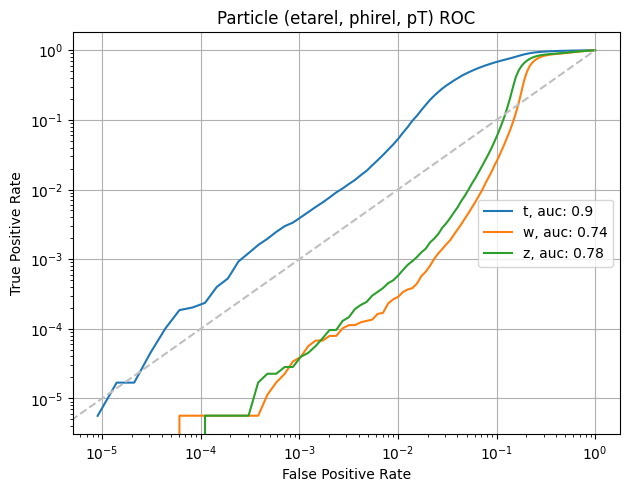

In [67]:
plot_auc(background_losses, [t_losses, w_losses, z_losses], ['t', 'w', 'z'])

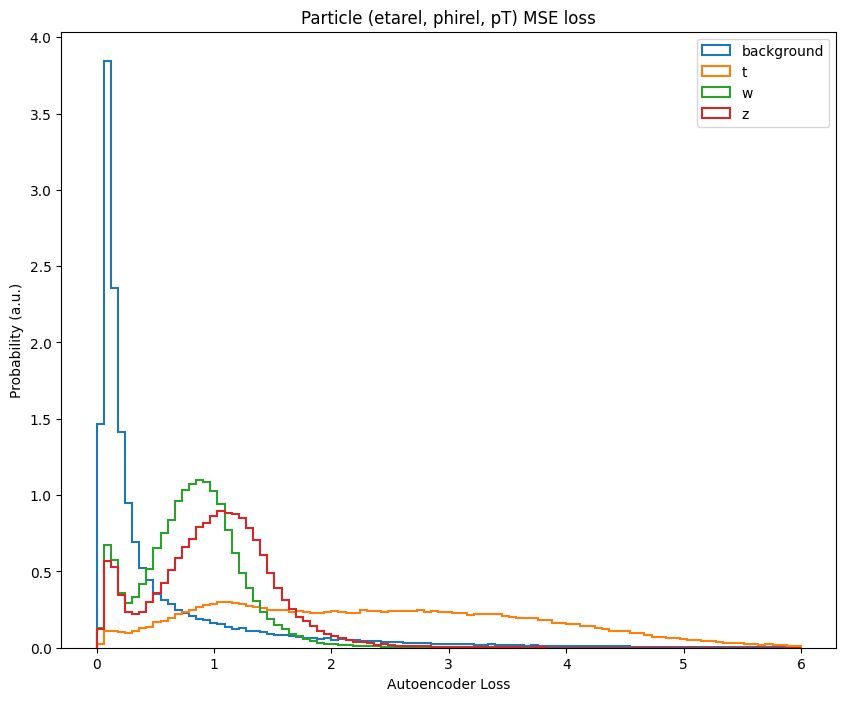

In [47]:
plot_histogram(background_losses, [t_losses, w_losses, z_losses], ['t', 'w', 'z'], bin_size = np.linspace(0, 6, 100))